In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import skimage
import skimage.io
import skimage.feature
import pandas as pd
% matplotlib inline

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from MobileNetV2 import MobileNetV2
from tensorboardX import SummaryWriter 
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# prepare dataset
class CelebADataSet(Dataset):
    def __init__(self, train_or_valid = "train", aug=True):
        
        if train_or_valid=="train":
            print("load train dataset")
            self.X = np.load("../features/train_X_original.npy")
            with open("../dlcv_final_2_dataset/train_id.txt","r") as f:
                train_y = f.readlines()
                self.y = [line.strip().split(" ")[1] for line in train_y]
                self.train_y = self.y
            
        elif train_or_valid=="valid":
            print("load valid dataset")
            self.X = np.load("../features/valid_X_original.npy")
            with open("../dlcv_final_2_dataset/val_id.txt","r") as f:
                valid_y = f.readlines()
                self.y = [line.strip().split(" ")[1] for line in valid_y]
            with open("../dlcv_final_2_dataset/train_id.txt","r") as f:
                train_y = f.readlines()
                self.train_y = [line.strip().split(" ")[1] for line in train_y]
        if aug == False:
            self.transform=transforms.Compose([transforms.ToPILImage(),
                          transforms.Pad((23,3), fill=0, padding_mode='constant'),
                          transforms.ToTensor(),
                         ])
        else:
            self.transform=transforms.Compose([transforms.ToPILImage(),
                                               transforms.Pad((23,3), fill=0, 
                                                              padding_mode='constant'),
                                               transforms.RandomAffine(degrees=30,
                                                                       translate=(0.15,0.15), 
                                                                       scale=(0.85,1.15)),   
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                             ])
        self.label_encoder = {}
        label_set = []
        index = 0
        for i in self.train_y:
            if i not in label_set:
                label_set.append(i)
                self.label_encoder[i] = index
                index += 1
                
    def __getitem__(self, index):
        """
        Args:
            index: the index of item 
        Returns:
            image and its labels
        """
        image = self.X[index]
        encoded_label = self.label_encoder[self.y[index]]
        label = encoded_label # no need for one hot encoding
        image = self.transform(image)
        return image, torch.tensor(label).type(torch.LongTensor)
    def __len__(self):
        return len(self.y)


train_dataset = CelebADataSet(train_or_valid="train", aug=True)
valid_dataset = CelebADataSet(train_or_valid="valid", aug=False)

load train dataset
load valid dataset


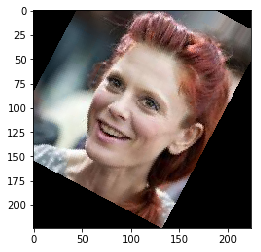

In [7]:
plt.imshow(train_dataset[1][0].numpy().transpose(1,2,0))

In [8]:
output_size = 2360

In [9]:
class mobileNet(nn.Module):
    def __init__(self):
        super(mobileNet, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, 2360)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [12]:
model = mobileNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,betas=(0.5,0.999))
BATCH_SIZE = 64
loss_function = nn.CrossEntropyLoss().cuda()

# DataLoader
train_loader = DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               
    num_workers=20,              
)

valid_loader = DataLoader(
    dataset=valid_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=False,  
    num_workers=20,              
)


In [17]:
max_accuracy = 0
model.train()
training_loss_list = []
validation_acc_list = []

writer = SummaryWriter(log_dir="../log/mobilenet_N01_aug")

# iteration = 0
for epoch in range(400,600):
    print("Epoch:", epoch+1)
    CE_loss = 0.0
    # construct training batch
    for step, (batch_x, batch_y) in enumerate(train_loader):
        iteration +=1 
        # zero the parameter gradients
        optimizer.zero_grad()
        # use GPU
        # forward + backward + optimize
        output = model(batch_x.cuda())
        # compute loss for each sample in training data
        loss = loss_function(output, batch_y.cuda())
        loss.backward()
        optimizer.step()
        CE_loss += loss.cpu().data.numpy()
        writer.add_scalar('loss', loss.data[0], iteration)
    print("training loss",CE_loss)
    
    training_loss_list.append(CE_loss)
    # validation
    same_difference = []
    with torch.no_grad():
        model.eval()
        valid_output = []
        valid_y_list = []
        for batch_X, batch_y in valid_loader:
            output = model(batch_X.cuda())
            prediction = torch.argmax(output.cpu(),1).data.numpy()
            valid_gt = batch_y.numpy()
            same_difference.append(prediction==valid_gt)

        accuracy = np.mean(np.concatenate(same_difference))
        validation_acc_list.append(accuracy)
        writer.add_scalar('accuracy', accuracy,  epoch+1)
        print("validation accuracy: ",accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
#         torch.save(model.state_dict(), "../models/RNN_seq2seq_model.pkt")
    model.train()

Epoch: 401


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


training loss 22.120875641703606
validation accuracy:  0.6251560116488698
Epoch: 402
training loss 19.255013793706894
validation accuracy:  0.6430453473859381
Epoch: 403
training loss 16.212352201342583
validation accuracy:  0.6449868256829844
Epoch: 404
training loss 17.7904160246253
validation accuracy:  0.6143392039938982
Epoch: 405
training loss 18.935583919286728
validation accuracy:  0.6451255027042019
Epoch: 406
training loss 18.161198415094987
validation accuracy:  0.6620440992927472
Epoch: 407
training loss 14.945544417249039
validation accuracy:  0.6437387324920261
Epoch: 408
training loss 16.083873093128204
validation accuracy:  0.644432117598114
Epoch: 409
training loss 16.640063263475895
validation accuracy:  0.6449868256829844
Epoch: 410
training loss 20.33288250118494
validation accuracy:  0.6476216890861184
Epoch: 411
training loss 17.25733884423971
validation accuracy:  0.6345860490916655
Epoch: 412
training loss 17.672852749936283
validation accuracy:  0.6560809873803

training loss 13.743972962722182
validation accuracy:  0.6541395090833448
Epoch: 499
training loss 14.216335624456406
validation accuracy:  0.6359728193038413
Epoch: 500
training loss 13.719064801931381
validation accuracy:  0.6517819997226459
Epoch: 501
training loss 14.74550215958152
validation accuracy:  0.6498405214255998
Epoch: 502
training loss 12.003476455807686
validation accuracy:  0.6599639439744834
Epoch: 503
training loss 14.71913541201502
validation accuracy:  0.6556649563167383
Epoch: 504
training loss 13.875787027180195
validation accuracy:  0.6531687699348218
Epoch: 505
training loss 15.888077875599265
validation accuracy:  0.6424906393010679
Epoch: 506
training loss 13.262726337648928
validation accuracy:  0.6524753848287339
Epoch: 507
training loss 13.800658002495766
validation accuracy:  0.6562196644016086
Epoch: 508
training loss 14.33168688416481
validation accuracy:  0.6193315767577312
Epoch: 509
training loss 11.161808141390793
validation accuracy:  0.65663569546

training loss 10.300166038330644
validation accuracy:  0.6620440992927472
Epoch: 596
training loss 11.079696159111336
validation accuracy:  0.6558036333379559
Epoch: 597
training loss 9.782111667911522
validation accuracy:  0.6666204409929275
Epoch: 598
training loss 10.984634814434685
validation accuracy:  0.6599639439744834
Epoch: 599
training loss 10.970849595963955
validation accuracy:  0.644432117598114
Epoch: 600
training loss 11.813528046011925
validation accuracy:  0.651088614616558
